In [7]:
pip install imbalanced-learn seaborn

Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import Pipeline

In [9]:
df=pd.read_csv('asthma_disease_data.csv')
df1=df

In [10]:
continuous_columns = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']
categorical_columns = ['Gender', 'Smoking']
median_imputer = SimpleImputer(strategy='median')
df[continuous_columns] = median_imputer.fit_transform(df[continuous_columns])
df_new=pd.get_dummies(df, columns=['Ethnicity','EducationLevel'])
df=df_new
mode_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = mode_imputer.fit_transform(df[categorical_columns])

scaler = MinMaxScaler()
df[continuous_columns] = scaler.fit_transform(df[continuous_columns])

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in continuous_columns:
    df = remove_outliers(df, col)
df2=df.drop(columns=['Diagnosis','DoctorInCharge','PatientID'], axis=1)
corr_matrix = df2.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
df_clean = df2.drop(columns=to_drop)

In [11]:
# print(X.columns)
# print(y.shape)
y = df1['Diagnosis']
X=df_clean
print(X.columns)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print(X_res.shape)
print(y_res.shape)
print(y_res.value_counts())


Index(['Age', 'Gender', 'BMI', 'Smoking', 'PhysicalActivity', 'DietQuality',
       'SleepQuality', 'PollutionExposure', 'PollenExposure', 'DustExposure',
       'PetAllergy', 'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema',
       'HayFever', 'GastroesophagealReflux', 'LungFunctionFEV1',
       'LungFunctionFVC', 'Wheezing', 'ShortnessOfBreath', 'ChestTightness',
       'Coughing', 'NighttimeSymptoms', 'ExerciseInduced', 'Ethnicity_0',
       'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'EducationLevel_0',
       'EducationLevel_1', 'EducationLevel_2', 'EducationLevel_3'],
      dtype='object')
(4536, 32)
(4536,)
Diagnosis
0    2268
1    2268
Name: count, dtype: int64


In [12]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

def scores(y_test, pred):
    print("Accuracy: ",accuracy_score(y_test, pred))
    print("Precision: ",precision_score(y_test, pred))
    print("Recall: ",recall_score(y_test, pred))
    print("F1 Score: ",f1_score(y_test, pred))
    print("ROC AUC Score: ",roc_auc_score(y_test, pred))
    cm = confusion_matrix(y_test, pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}


k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

Random Forest Classifier
Accuracy:  0.973568281938326
Precision:  0.9935691318327974
Recall:  0.9507692307692308
F1 Score:  0.9716981132075472
ROC AUC Score:  0.9725756266205705
[[354   2]
 [ 16 309]]


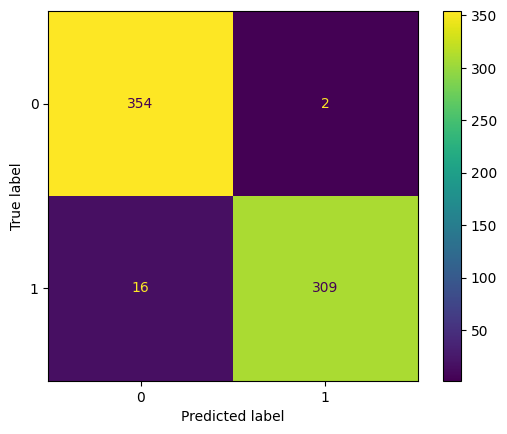

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.15, random_state=42)
rf=RandomForestClassifier(random_state=20)
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', rf)
])
cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)
model = pipeline.fit(X_train, y_train)
print("Random Forest Classifier")
y_pred = model.predict(X_test)
scores(y_test, y_pred)

Decision Tree Classifier
Accuracy:  0.9016152716593245
Precision:  0.8909090909090909
Recall:  0.9046153846153846
F1 Score:  0.8977099236641222
ROC AUC Score:  0.9017458945548833
[[320  36]
 [ 31 294]]


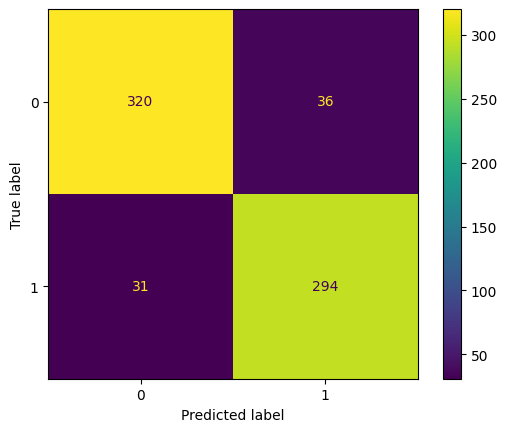

In [14]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(random_state=20)
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', dt)
])
cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)
print("Decision Tree Classifier")
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
scores(y_test, y_pred)


c:\Users\Samridh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Samridh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

Logistic Regression Classifier
Accuracy:  0.9133627019089574
Precision:  0.9716312056737588
Recall:  0.8430769230769231
F1 Score:  0.9028006589785832
ROC AUC Score:  0.9103025064822817
[[348   8]
 [ 51 274]]


c:\Users\Samridh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


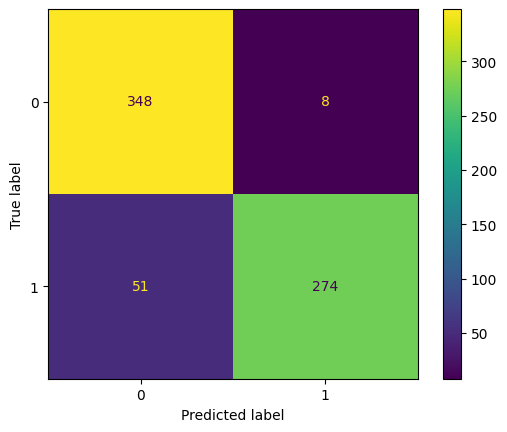

In [15]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', lgr)
])
cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)
print("Logistic Regression Classifier")
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
scores(y_test, y_pred)

SVM Classifier
Accuracy:  0.9280469897209985
Precision:  0.9630872483221476
Recall:  0.8830769230769231
F1 Score:  0.9213483146067416
ROC AUC Score:  0.9260890233362143
[[345  11]
 [ 38 287]]


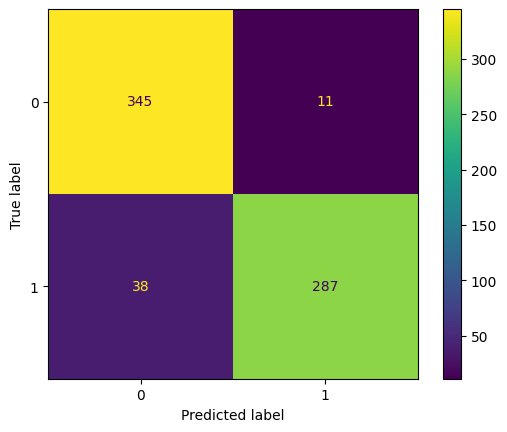

In [16]:
from sklearn.svm import SVC
sv = SVC()
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', sv)
])
cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)
print("SVM Classifier")
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
scores(y_test, y_pred)

## EDA

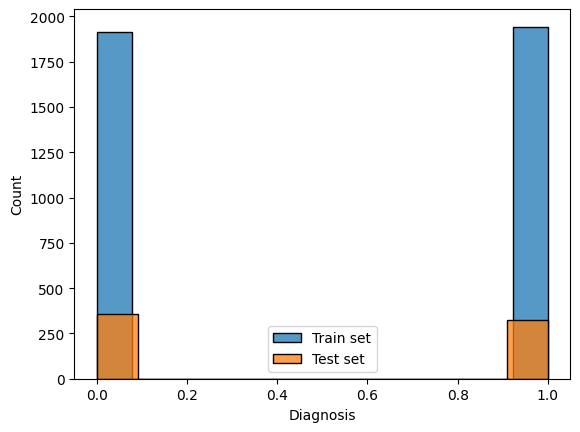

In [17]:
import seaborn as sns

sns.histplot(y_train, label="Train set")
sns.histplot(y_test, label="Test set")
plt.legend()

In [18]:
train_df = pd.concat([X_train, y_train], axis=1)

print(len(train_df.columns))
for col in train_df.columns:
    print(col)

33
Age
Gender
BMI
Smoking
PhysicalActivity
DietQuality
SleepQuality
PollutionExposure
PollenExposure
DustExposure
PetAllergy
FamilyHistoryAsthma
HistoryOfAllergies
Eczema
HayFever
GastroesophagealReflux
LungFunctionFEV1
LungFunctionFVC
Wheezing
ShortnessOfBreath
ChestTightness
Coughing
NighttimeSymptoms
ExerciseInduced
Ethnicity_0
Ethnicity_1
Ethnicity_2
Ethnicity_3
EducationLevel_0
EducationLevel_1
EducationLevel_2
EducationLevel_3
Diagnosis


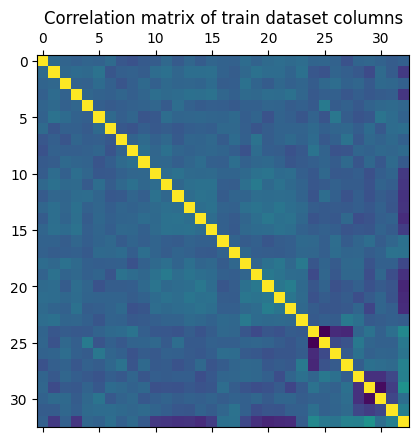

In [19]:
plt.matshow(train_df.corr())
plt.title('Correlation matrix of train dataset columns')
plt.show()

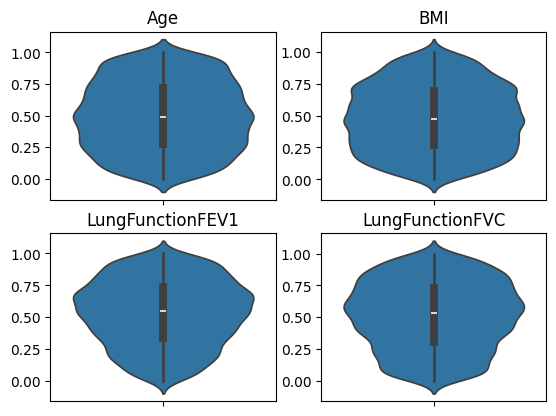

In [20]:
cols = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']

fig, axes = plt.subplots(nrows=2, ncols=2)

counter = 0
for col in cols:
    sns.violinplot(train_df[col], ax=axes[counter // 2, counter % 2])
    axes[counter // 2, counter % 2].set_ylabel("")
    axes[counter // 2, counter % 2].set_title(col)
    counter += 1

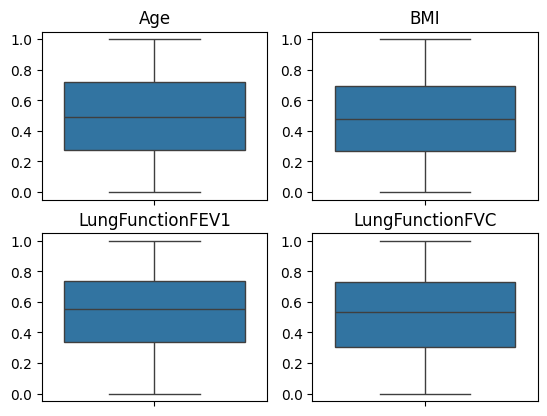

In [21]:
cols = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']

fig, axes = plt.subplots(nrows=2, ncols=2)

counter = 0
for col in cols:
    sns.boxplot(train_df[col], ax=axes[counter // 2, counter % 2])
    axes[counter // 2, counter % 2].set_ylabel("")
    axes[counter // 2, counter % 2].set_title(col)
    counter += 1


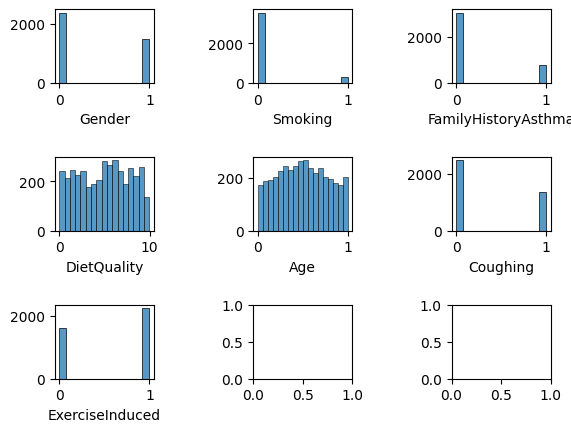

In [22]:
cols = ['Gender', 'Smoking', 'FamilyHistoryAsthma', 'DietQuality', 'Age', 'Coughing', 'ExerciseInduced']

fig, axes = plt.subplots(nrows=3, ncols=3)

fig.subplots_adjust(hspace=1, wspace=1)

counter = 0
for col in cols:
    sns.histplot(train_df[col], ax=axes[counter // 3, counter % 3])
    axes[counter // 3, counter % 3].set_ylabel("")
    counter += 1



## EDA on original dataset

<Axes: xlabel='Diagnosis', ylabel='Count'>

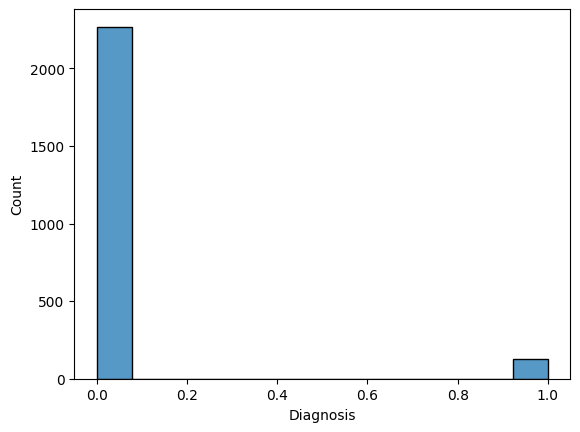

In [23]:
sns.histplot(df1['Diagnosis'])

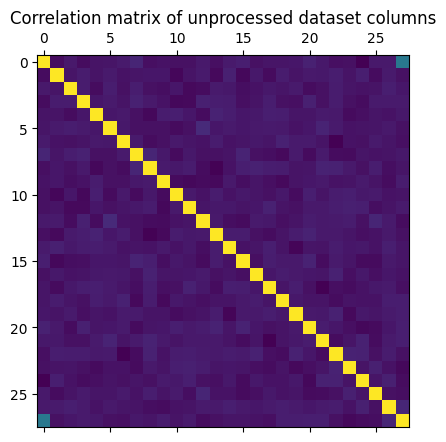

In [24]:
df1.drop('DoctorInCharge', axis=1, inplace=True)
plt.matshow(df1.corr())
plt.title('Correlation matrix of unprocessed dataset columns')
plt.show()


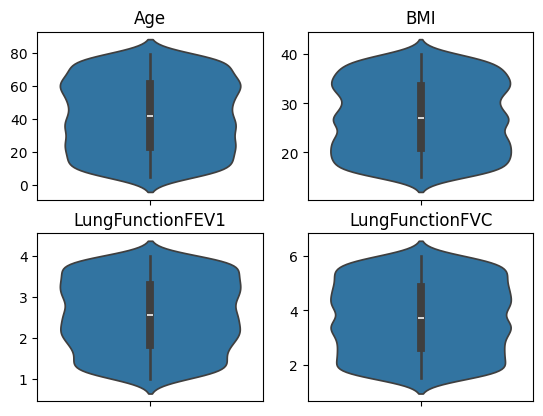

In [25]:
cols = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']

fig, axes = plt.subplots(nrows=2, ncols=2)

counter = 0
for col in cols:
    sns.violinplot(df1[col], ax=axes[counter // 2, counter % 2])
    axes[counter // 2, counter % 2].set_ylabel("")
    axes[counter // 2, counter % 2].set_title(col)
    counter += 1

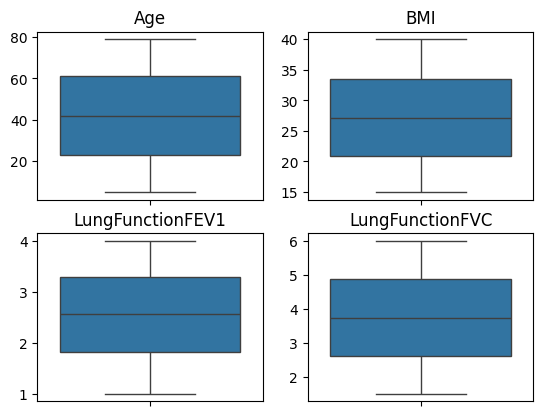

In [26]:
cols = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']

fig, axes = plt.subplots(nrows=2, ncols=2)

counter = 0
for col in cols:
    sns.boxplot(df1[col], ax=axes[counter // 2, counter % 2])
    axes[counter // 2, counter % 2].set_ylabel("")
    axes[counter // 2, counter % 2].set_title(col)
    counter += 1


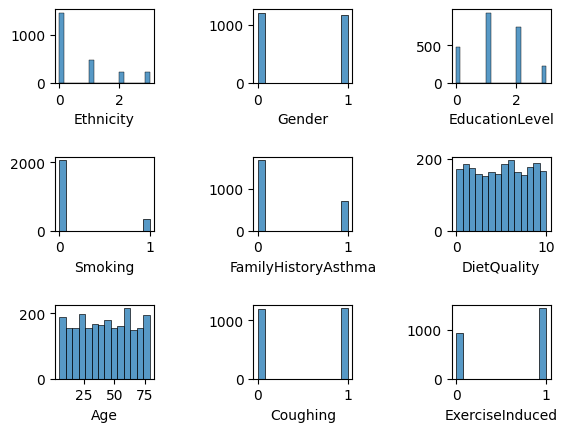

In [27]:
cols = ['Ethnicity', 'Gender', 'EducationLevel', 'Smoking', 'FamilyHistoryAsthma', 'DietQuality', 'Age', 'Coughing', 'ExerciseInduced']

fig, axes = plt.subplots(nrows=3, ncols=3)

fig.subplots_adjust(hspace=1, wspace=1)

counter = 0
for col in cols:
    sns.histplot(df1[col], ax=axes[counter // 3, counter % 3])
    axes[counter // 3, counter % 3].set_ylabel("")
    counter += 1



In [28]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

Accuracy:  0.7650513950073421
Precision:  0.7165354330708661
Recall:  0.84
F1 Score:  0.773371104815864
ROC AUC Score:  0.7683146067415729
[[248 108]
 [ 52 273]]


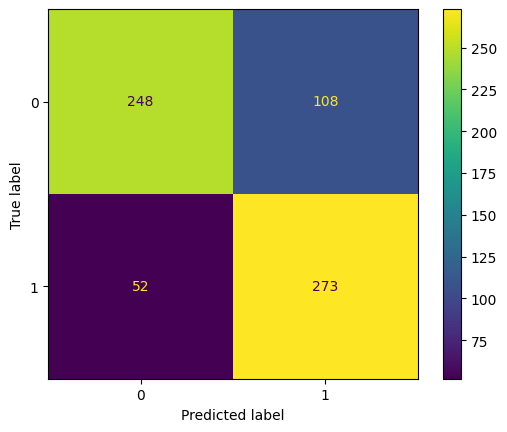

c:\Users\Samridh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [43]:
import pydotplus
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

import pickle

X_train_new=X_train
feature_names=X_train_new.columns
X_test_new=X_test
model_1=DecisionTreeClassifier(random_state=20,max_depth=4)
model_1.fit(X_train_new,y_train)
pred_1=model_1.predict(X_test_new)
scores(y_test, pred_1)
# save model
filename = 'dt.pkl'
pickle.dump(model_1, open(filename, 'wb'))

class_names = ['No Asthma', 'Asthma']
pydotplus.find_graphviz = lambda: {"dot": r"C:\Program Files\Graphviz\bin\dot.exe"}

dot_data = tree.export_graphviz(model_1, out_file=None,
                                feature_names=feature_names,
                                class_names=class_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.replace('\n', ''))

# empty all nodes, i.e.set color to white and number of samples to zero
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')
for i in range(1):
    input_data = np.array(X_test_new.iloc[i])
    samples = input_data.reshape(1, -1)
    decision_paths = model_1.decision_path(samples)

    for decision_path in decision_paths:
        for n, node_value in enumerate(decision_path.toarray()[0]):
            if node_value == 0:
                continue
            node = graph.get_node(str(n))[0]            
            node.set_fillcolor('green')
            labels = node.get_attributes()['label'].split('<br/>')
            for i, label in enumerate(labels):
                if label.startswith('samples = '):
                    labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

            node.set('label', '<br/>'.join(labels))
    filename = f'tree_{i+1}.png'
    graph.write_png(filename)

In [44]:
import tkinter as tk

dt_modle = pickle.load(open('dt.pkl', 'rb'))

import tkinter as tk
from tkinter import messagebox

# Initialize an empty dataframe with the given columns
columns = [
    'Age', 'Gender', 'BMI', 'Smoking', 'PhysicalActivity', 'DietQuality',
    'SleepQuality', 'PollutionExposure', 'PollenExposure', 'DustExposure',
    'PetAllergy', 'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema',
    'HayFever', 'GastroesophagealReflux', 'LungFunctionFEV1',
    'LungFunctionFVC', 'Wheezing', 'ShortnessOfBreath', 'ChestTightness',
    'Coughing', 'NighttimeSymptoms', 'ExerciseInduced', 'Ethnicity_0',
    'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'EducationLevel_0',
    'EducationLevel_1', 'EducationLevel_2', 'EducationLevel_3'
]
data_inputed = pd.DataFrame(columns=columns)

# Function to collect input and add to the dataframe
def submit_data():
    row = {}
    for col, entry in input_entries.items():
        value = entry.get()
        if col=='EducationLevel':
            if value==0:
                row['EducationLevel_0'] = 1
                row['EducationLevel_1'] = 0
                row['EducationLevel_2'] = 0
                row['EducationLevel_3'] = 0
            elif value==1:
                row['EducationLevel_0'] = 0
                row['EducationLevel_1'] = 1
                row['EducationLevel_2'] = 0
                row['EducationLevel_3'] = 0
            elif value==2:
                row['EducationLevel_0'] = 0
                row['EducationLevel_1'] = 0
                row['EducationLevel_2'] = 1
                row['EducationLevel_3'] = 0
            else:
                row['EducationLevel_0'] = 0
                row['EducationLevel_1'] = 0
                row['EducationLevel_2'] = 0
                row['EducationLevel_3'] = 1
        else:
            row[col] = value
    # Append the row to the dataframe
    global data_inputed
    data_inputed = pd.concat([data_inputed, pd.DataFrame([row])], ignore_index=True)
    messagebox.showinfo("Success", "Data submitted successfully!")
    # Clear the entries after submission
    for entry in input_entries.values():
        entry.delete(0, tk.END)

# Function to save the dataframe to a CSV file
def save_data():
    data_inputed.to_csv("submitted_data.csv", index=False)
    messagebox.showinfo("Saved", "Data saved to 'submitted_data.csv'!")

# Create Tkinter window
root = tk.Tk()
root.title("Input Form")

# Create input fields for the selected columns
selected_columns = [
    'ChestTightness', 'HayFever', 'FamilyHistoryAsthma', 'Coughing',
     'HistoryOfAllergies', 'PollutionExposure',
    'PetAllergy', 'EducationLevel', 'PhysicalActivity', 'ShortnessOfBreath',
    'PollenExposure', 'DietQuality'
]
input_entries = {}

# Add labels and entry fields to the form
for i, col in enumerate(selected_columns):
    label = tk.Label(root, text=col)
    label.grid(row=i, column=0, padx=10, pady=5, sticky='e')
    entry = tk.Entry(root)
    entry.grid(row=i, column=1, padx=10, pady=5, sticky='w')
    input_entries[col] = entry

# Add Submit and Save buttons
submit_button = tk.Button(root, text="Submit", command=submit_data)
submit_button.grid(row=len(selected_columns), column=0, pady=10, padx=10, sticky='e')

save_button = tk.Button(root, text="Save to CSV", command=save_data)
save_button.grid(row=len(selected_columns), column=1, pady=10, padx=10, sticky='w')

# Run the Tkinter main loop
root.mainloop()
print(data_inputed)

# y_pred = dt_modle.predict(X_test_new)
# scores(y_test, y_pred)

   Age Gender  BMI Smoking PhysicalActivity DietQuality SleepQuality  \
0  NaN    NaN  NaN     NaN                0           0          NaN   

  PollutionExposure PollenExposure DustExposure  ... NighttimeSymptoms  \
0                 0              0          NaN  ...               NaN   

  ExerciseInduced Ethnicity_0 Ethnicity_1 Ethnicity_2 Ethnicity_3  \
0             NaN         NaN         NaN         NaN         NaN   

  EducationLevel_0 EducationLevel_1 EducationLevel_2 EducationLevel_3  
0                0                0                0                1  

[1 rows x 32 columns]


In [45]:
import pickle as pk
# print(data_inputed)
for col in data_inputed.columns:
    if data_inputed[col].isna().sum() > 0:
        nan_mask = data_inputed[col].isna()
        random_samples = X_train[col].dropna().sample(
                n=nan_mask.sum(), replace=True, random_state=42
        ).values
        data_inputed.loc[nan_mask, col] = random_samples


df_new_model=pk.load(open('dt.pkl','rb'))
# print(data_inputed)
dot_data = tree.export_graphviz(df_new_model, out_file=None,
                                feature_names=feature_names,
                                class_names=class_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.replace('\n', ''))

# empty all nodes, i.e.set color to white and number of samples to zero
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')


y_pred = df_new_model.predict(data_inputed)
print(y_pred)
for i in range(1):
    input_data = np.array(data_inputed.iloc[i])
    samples = input_data.reshape(1, -1)
    decision_paths = model_1.decision_path(samples)

    for decision_path in decision_paths:
        for n, node_value in enumerate(decision_path.toarray()[0]):
            if node_value == 0:
                continue
            node = graph.get_node(str(n))[0]            
            node.set_fillcolor('green')
            labels = node.get_attributes()['label'].split('<br/>')
            for i, label in enumerate(labels):
                if label.startswith('samples = '):
                    labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

            node.set('label', '<br/>'.join(labels))
    filename = f'tree_predict_{i+1}.png'
    graph.write_png(filename)

[1]


c:\Users\Samridh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Train set outliers:  2599
Train set inliers:  1256
Accuracy:  0.869309838472834
Precision:  1.0
Recall:  0.7261538461538461
F1 Score:  0.8413547237076648
ROC AUC Score:  0.8630769230769231
[[356   0]
 [ 89 236]]


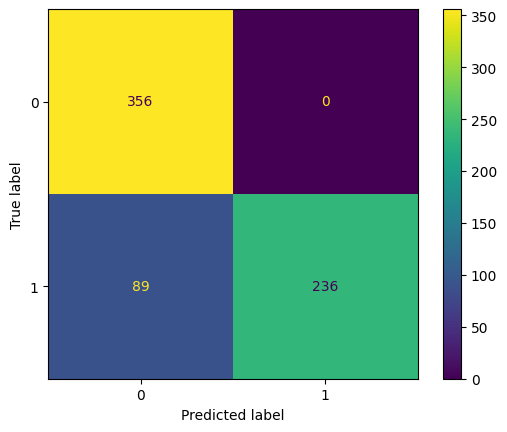

In [31]:
from sklearn.ensemble import IsolationForest
import pickle as pk
clf = IsolationForest(random_state=20)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
print("Train set outliers: ", len(y_pred_train[y_pred_train == -1]))
print("Train set inliers: ", len(y_pred_train[y_pred_train == 1]))

# print accuracy after removing outliers
X_train_clean = X_train[y_pred_train == -1]
y_train_clean = y_train[y_pred_train == -1]

model = RandomForestClassifier(random_state=20)
model.fit(X_train_clean, y_train_clean)
pred = model.predict(X_test)
scores(y_test, pred)
pk.dump(model, open('rf_model_iff.pkl', 'wb'))


In [32]:
# perform grid-search with k-fold valdiation for hyperparameter tuning
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier

# X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.15, random_state=42)

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 10, 15, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# rf = RandomForestClassifier(random_state=20)
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=skf, scoring='accuracy')
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)
# print(grid_search.best_score_)
# model = grid_search.best_estimator_
# pred = model.predict(X_test)
# scores(y_test, pred)
# # save model in pickle file
# import pickle
# filename = 'rf_model.pkl'
# pickle.dump(model, open(filename, 'wb'))

Accuracy:  0.973568281938326
Precision:  0.9935691318327974
Recall:  0.9507692307692308
F1 Score:  0.9716981132075472
ROC AUC Score:  0.9725756266205705
[[354   2]
 [ 16 309]]


c:\Users\Samridh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Samridh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


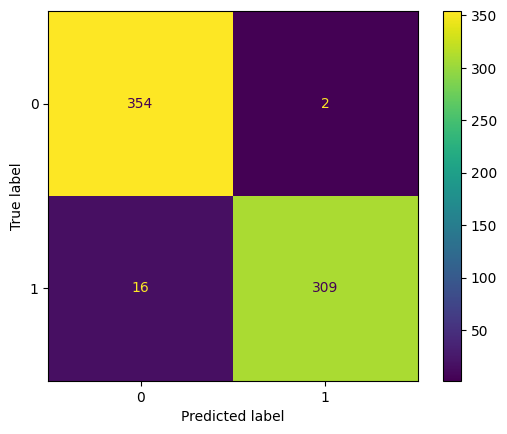

In [33]:
grid_modle = pickle.load(open('grid_model.pkl', 'rb'))
pred = grid_modle.predict(X_test)
scores(y_test, pred)

GMM Classifier
Accuracy:  0.38179148311306904
Precision:  0.15217391304347827
Recall:  0.06461538461538462
F1 Score:  0.09071274298056156
ROC AUC Score:  0.3679818496110631
[[239 117]
 [304  21]]


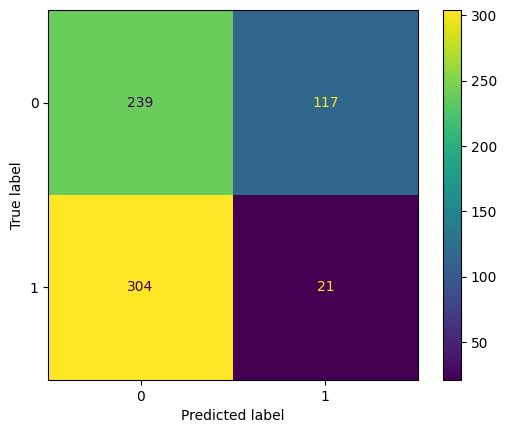

KMeans Classifier
Accuracy:  0.5242290748898678
Precision:  0.5015479876160991
Recall:  0.49846153846153846
F1 Score:  0.5
ROC AUC Score:  0.5231071737251513
[[195 161]
 [163 162]]


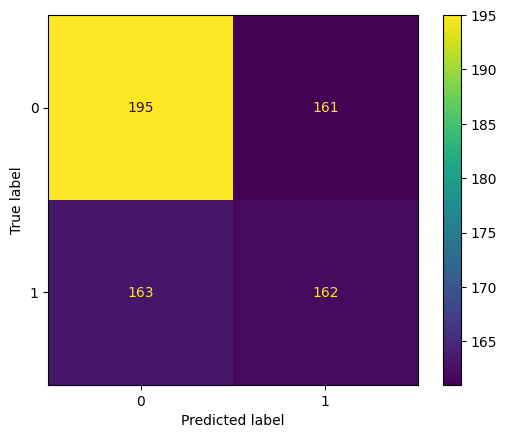

In [34]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

# do train test split from x_res and y_res
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.15, random_state=42)

# apply gmm
gmm = GaussianMixture(n_components=2, random_state=42)
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', gmm)
])
cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)
print("GMM Classifier")
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
scores(y_test, y_pred)

# apply kmeans
kmeans = KMeans(n_clusters=2, random_state=42)
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', kmeans)
])
cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)
print("KMeans Classifier")
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
scores(y_test, y_pred)